In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

(96, 96, 3)


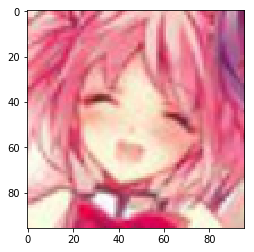

In [20]:
img = np.array(Image.open(r'/Users/liziniu/documents/girl3.jpeg'))
print(img.shape)
plt.imshow(img)

In [3]:
def is_in(point, vertex):
    p1, p2, p3, p4 = vertex
    p = [p1, p2, p3, p4, p1]
    c = []
    for i in range(4):
        c.append(np.cross(p[i]-point, p[i]-p[i+1]))
    c.append(c[0])
    c /= max(c)
    flag = True
    for i in range(4):
        if c[i] * c[i+1] < 0:
            flag = False     
            break
    return flag

In [4]:
def cal_outputsize(shape, a, b, kind='loose'):
    h, w = shape
    p1 = np.array([0, 0])
    p2 = np.array([0, h])
    p3 = np.array([w, h])
    p4 = np.array([w, 0])
    p = [p1, p2, p3, p4]
    p_ = []
    b = b.ravel(_)
    assert b.shape == (2,)
    for i in range(4):
      p_.append(np.dot(a, p[i]) + b)
    
    assert kind == 'loose' or kind == 'crop'
    if kind == 'crop':
        out_size = (h, w)
        shift = (0, 0)
    if kind == 'loose':
        max_x = -np.inf
        max_y = -np.inf
        min_x = np.inf
        min_y = np.inf
        for i in range(4):
            if p_[i][0] > max_x:
                max_x = p_[i][0]
            if p_[i][1] > max_y:
                max_y = p_[i][1]
            if p_[i][0] < min_x:
                min_x = p_[i][0]
            if p_[i][1] < min_y:
                min_y = p_[i][1]
        out_size = (max_y - min_y, max_x - min_x)
        shift = (min_x, min_y)
    return out_size, p_, shift

In [10]:
def background_geometry(inputIm, A, kind='loose'):
    # prepare
    in_img = np.array(inputIm)
    arr = np.array(A)
    a, b = arr[:, :-1], arr[:, -1]
    h, w, c = in_img.shape
    assert a.shape == (2, 2), b.shape==(2, 1)
    
    # calculate the output image shape
    outputsize, vertex_, shift = cal_outputsize(in_img.shape[:2], a, b, kind)
    h_, w_ = outputsize
    c_ = c
    h_, w_, c_ = int(h_), int(w_), int(c_)
    out_img = np.zeros((h_, w_, c_))
   
    # backgroud
    count = 0
    for x_ in range(w_):
        x_temp = int(x_)
        x_ += shift[0]
        for y_ in range(h_):
                y_temp =  int(y_)
                y_ += shift[1]
                p = np.array([x_, y_])
                # out of range
                if not is_in(p, vertex_):
                    continue
                # inverse transform
                coor = np.dot(np.linalg.inv(a), (np.array([x_, y_]) - b).reshape(2, 1))
                x, y = coor[0, 0], coor[1, 0]
                    
                # back_ground
                left, top = int(np.floor(x)), int(np.floor(y))
                right, down = int(np.ceil(x)), int(np.ceil(y))
                if right == left and down == top:       
                    try:
                        out_img[y_temp, x_temp, :] = in_img[top, left, :]
                        count += 1
                    except:
                        # for the reason of numerical solution
                        top = np.clip(top, 0, h-1)
                        left = np.clip(left, 0, w-1)
                        out_img[y_temp, x_temp, :] = in_img[top, left, :]
                        
                else:
                    try:
                        delta_x, delta_y = x - left, y - top
                        out_img[y_temp, x_temp, :] = (1-delta_x)*(1-delta_y)*in_img[top, left, :] + (1-delta_x)*delta_y*in_img[top, right, :] +\
                                         (1-delta_y)*delta_x*in_img[down, left, :] + delta_x*delta_y*in_img[down, right, :]
                        count += 1
                    except:
                        top = np.clip(top, 0, h-1)
                        left = np.clip(left, 0, w-1)
                        out_img[y_temp, x_temp, :] = in_img[top, left, :]

    # print("count", count)        
    return out_img

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  if __name__ == '__main__':


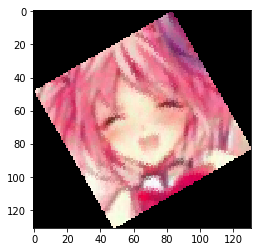

In [24]:
cita = -np.pi/6
a = np.array([[np.cos(cita), -np.sin(cita)], [np.sin(cita), np.cos(cita)]]).reshape(2, 2)
b = np.array([[2], [2]])
A = np.hstack((a, b))
new_img = background_geometry(img, A, kind='loose').astype('uint8')
plt.imshow(new_img)